In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

Create a list of low infection efficiency wells and outlier wells. These wells should be excluded from the analysis.

In [2]:
# Function for generating the Otsu threshold
# Functions from https://bic-berkeley.github.io/psych-214-fall-2016/otsu_threshold.html


def ssd(hist, bin_centers):
    """
    Calculates the sum of squared differences between the histogram and the bin centers weighted by the histogram values.
    Parameters
    ----------
        hist : numpy.ndarray
            Histogram.
        bin_centers : numpy.ndarray
            Bin centers.
    Returns
    -------
        float: The sum of squared differences between the histogram and the bin centers weighted by the histogram values.
    """

    n = np.sum(hist)
    mu = np.sum(bin_centers * hist) / n
    return np.sum(hist * ((bin_centers - mu) ** 2))


def otsu_threshold(values):
    """
    Calculates the Otsu threshold.
    Parameters
    ----------
        values : numpy.ndarray
            Values.
    Returns
    -------
        float: The Otsu threshold.
    """
    n_bins = 100
    hist, bin_edges = np.histogram(values, bins=n_bins)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

    total_ssds = []

    for bin in range(1, n_bins):
        left_ssd = ssd(hist[:bin], bin_centers[:bin])
        right_ssd = ssd(hist[bin:], bin_centers[bin:])
        total_ssds.append(left_ssd + right_ssd)

    z = np.argmin(total_ssds)
    threshold = bin_centers[z]
    return threshold

In [3]:
# Read infection efficiency data

inf_eff_df_all = pd.read_csv(
    "output/gpp-infection-efficiencies.csv.gz",
    usecols=[
        "Plate_name",
        "Well",
        "broad_sample",
        "Minus_Avg_Background",
    ],
).rename(
    columns={
        "broad_sample": "Metadata_broad_sample",
        "Plate_name": "Metadata_plate_map_name",
        "Well": "Metadata_Well",
        "Minus_Avg_Background": "Metadata_Minus_Avg_Background",
    }
)

inf_eff_df_all.head()

,Metadata_plate_map_name,Metadata_Well,Metadata_broad_sample,Metadata_Minus_Avg_Background
0,OAB84.85.86.87.A,A01,ccsbBroad304_08631,0.825173
1,OAB84.85.86.87.A,A02,ccsbBroad304_06113,0.891887
2,OAB84.85.86.87.A,A03,ccsbBroad304_08850,0.520294
3,OAB84.85.86.87.A,A04,EMPTY,0.005996
4,OAB84.85.86.87.A,A05,ccsbBroad304_13853,0.938145


In [4]:
# Calculate Otsu threshold

# filter out outliers

temp_df = inf_eff_df_all.query("Metadata_Minus_Avg_Background < 2")

otsu_threshold_value = otsu_threshold(temp_df.Metadata_Minus_Avg_Background.values)
print(otsu_threshold_value)

0.4732191320151499


In [5]:
# Filter out wells with low infection efficiency and outliers.

inf_eff_df_filtered = inf_eff_df_all.query(
    "Metadata_Minus_Avg_Background < @otsu_threshold_value or Metadata_Minus_Avg_Background > 2"
)

inf_eff_df_filtered.shape

(2042, 4)

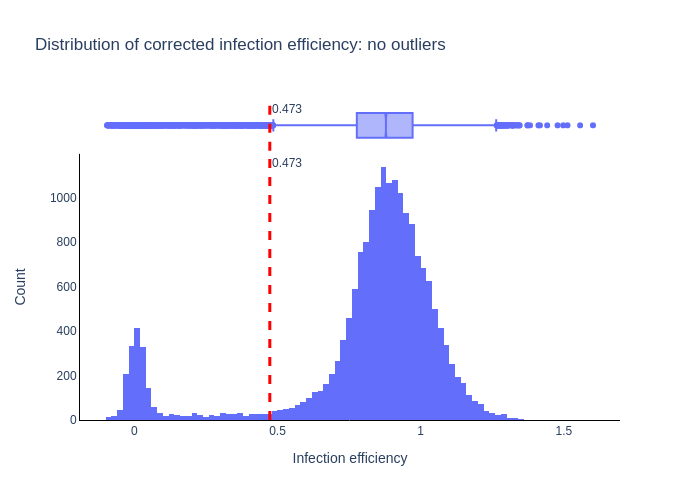

In [6]:
# Histogram of Minus_Avg_Background (i.e. corrected infection efficiency)

fig = px.histogram(
    inf_eff_df_all.query("Metadata_Minus_Avg_Background < 2"),
    x="Metadata_Minus_Avg_Background",
    marginal="box",
    title="Distribution of corrected infection efficiency: no outliers",
).add_vline(
    x=otsu_threshold_value,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text=f"{otsu_threshold_value:.3f}",
).update_layout(
    xaxis=dict(title="Infection efficiency", linecolor="black"),
    yaxis=dict(title="Count", linecolor="black"),
    plot_bgcolor="rgba(0,0,0,0)",
)

fig.show("png")
fig.write_image(
    "figures/infection_efficiency_histogram_no_outliers_at_otsu_threshold.png",
    width=640,
    height=480,
    scale=2,
)
fig.write_image(
    "figures/infection_efficiency_histogram_no_outliers_at_otsu_threshold.svg",
    width=640,
    height=480,
    scale=2,
)

In [7]:
# Filter out reagents in the platemap `OAB41.OAC17.OAB78.79.A` because of some `EMPTY` wells showing high infection efficiency

inf_eff_df_all_empty_high_infection_efficiency = inf_eff_df_all.query(
    "Metadata_plate_map_name == 'OAB41.OAC17.OAB78.79.A'"
)

inf_eff_df_all_empty_high_infection_efficiency.head()

,Metadata_plate_map_name,Metadata_Well,Metadata_broad_sample,Metadata_Minus_Avg_Background
4608,OAB41.OAC17.OAB78.79.A,A01,ccsbBroad304_13635,0.715532
4609,OAB41.OAC17.OAB78.79.A,A02,ccsbBroad304_11304,0.873497
4610,OAB41.OAC17.OAB78.79.A,A03,ccsbBroad304_08447,0.985337
4611,OAB41.OAC17.OAB78.79.A,A04,ccsbBroad304_03004,0.908971
4612,OAB41.OAC17.OAB78.79.A,A05,EMPTY,-0.075809


In [8]:
inf_eff_df_filtered = (
    pd.concat([inf_eff_df_filtered, inf_eff_df_all_empty_high_infection_efficiency], ignore_index=True)
    .drop_duplicates()
)
inf_eff_df_filtered.shape

(2397, 4)

In [9]:
# Write filtered data to file

inf_eff_df_filtered.to_csv(
    "output/orf-reagents-low-infection-efficiency-and-outliers.csv.gz", index=False
)